https://github.com/arthurdiercu/CSCA_5642_week_3

## Week 3: CNN Cancer Detection Kaggle Mini-Project

#### Problem:
The objective of this challenge is to predict whether small image patches from digital pathology slides contain tumor cells.
The training dataset contains about 220,000 images with labels indicating the presence or absence of metastatic cancer.

The goal of the project is to build a binary image classifier to detect metastatic cancer in small histopathologic image pathches.

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input


#### Exploratory Data Analysis (EDA):
Explore the data using basic statistics and visualizations. Class distribution, missing data checks, and image previews.

Each sample is a .tiff image and has a label associated with them, 1 or 0.
1, Indicating the presence of metastatic tissue and 0, Indicates the absence of the tumor tissue. The data includes 220025 samples

In [14]:
# load
train_labels = pd.read_csv("train_labels\\train_labels.csv")

print(train_labels.shape)
train_labels.head()


(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Visualized the number of non-tumor to tumor labels from the dataset. There is an imbalance, about 40000 more non-tumor images than tumor.

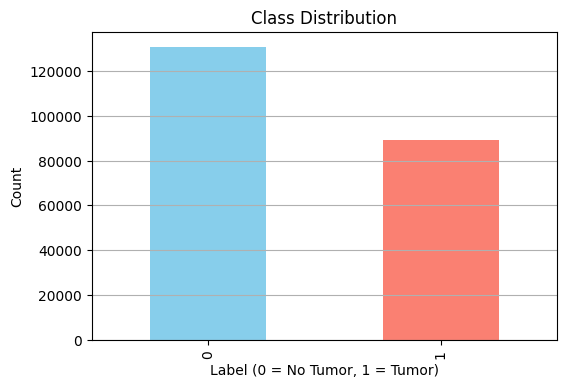

Label Counts:
Label 0: 130908 images
Label 1: 89117 images


In [15]:
plt.figure(figsize=(6,4))
train_labels['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Label (0 = No Tumor, 1 = Tumor)')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

label_counts = train_labels['label'].value_counts()
print("Label Counts:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

In [16]:
display(train_labels.isna().sum())

id       0
label    0
dtype: int64

In [17]:
img_dir = ".\\train\\"

def show_images(label_value, n=5):
    sample_ids = train_labels[train_labels['label'] == label_value]['id'].values[:n]
    plt.figure(figsize=(15,3))
    for i, img_id in enumerate(sample_ids):
        img_path = os.path.join(img_dir, f"{img_id}.tif")

        try:
            img = Image.open(img_path).convert('RGB')
            img_np = np.array(img)

            plt.subplot(1, n, i+1)
            plt.imshow(img_np)
            plt.title(f"Label: {label_value}")
            plt.axix('off')
        except Exception as e:
            # print(f"Error loading image {img_id}: {e}")
            continue
    plt.show()

Based on the data, the use of .tif (images), use Image Data Generator to process. Train a baseline CNN to set a benchmark and then experiment with a transfer learning attempting to get better feature extraction.

Tumor Examples:


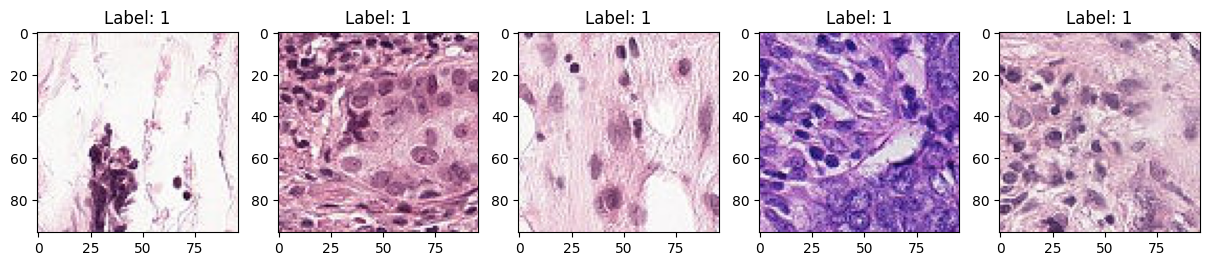

In [18]:
print("Tumor Examples:")
show_images(1)

Non-Tumor Examples:


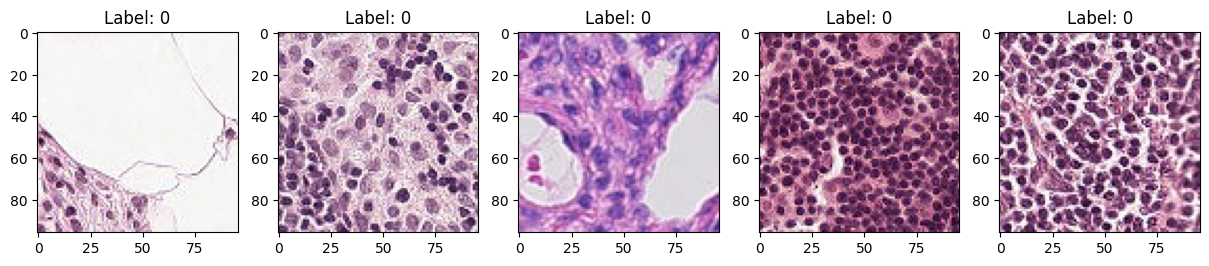

In [19]:
print("Non-Tumor Examples:")
show_images(0)

Check to see if any files are missing.

In [20]:
img_files = set(os.listdir(img_dir))
missing_files = []

for img_id in train_labels['id']:
    if f"{img_id}.tif" not in img_files:
        missing_files.append(img_id)

print(f"Missing files: {len(missing_files)}")

Missing files: 0


Make sure all images are 96x96 RGB.

In [21]:
sample_path = os.path.join(img_dir, train_labels['id'].iloc[0] + '.tif')
img = img_to_array(load_img(sample_path))
print("Image shape:", img.shape)

Image shape: (96, 96, 3)


In [22]:
train_labels.describe()


,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [23]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Baseline CNN: Implemented a Convolutional Neural Network using TensorFlow/Keras. This is a good starting point for benchmarking, simple and fast to train. The model has 1731905 trainable parameters. Most of the parameters concentrated in the fully connected later, which can be regularized via dropout. Dropout is set to .5 to prevent overfitting.
Conv2D at 32 filters, extracts low-level features like edges and textures using 3x3 kernels. We increase (2x) Conv2D.
MaxPooling2D reduces spatial dimensions by taking the max value in 2x2 windows.

In [24]:
def build_baseline_cnn(input_shape=(96, 96, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model

Here we run the build_baseline_cnn function.

In [25]:
baseline_model = build_baseline_cnn()
baseline_model.summary()

c:\College\CU_Boulder\Machine Learning\CSCA_5642\Week 3\project\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Transfer Learning (Pre-trained CNN): After the baseline CNN, the approach using transfer learning ws used. This leverages feature extraction power of a pre-trained network to improve the performance.
EfficientNetB0 was used, known for efficiency and for being robust.
The model summary shows: total parameters of 4213668, trainable parameters of 164097, non-trainable of 4049571, and the model size is about 16 MB.

In [26]:
input_tensor = Input(shape=(96, 96, 3), name="image_input")

def build_transfer_model(input_shape=(96, 96, 3)):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model

In [27]:
transfer_model = build_transfer_model()
transfer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 96, 96, 3) │          0 │ image_input[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 96, 96, 3) │          7 │ rescaling[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 96, 96, 3) │          0 │ normalization[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 97, 97, 3) │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 48, 48,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 48, 48,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 48, 48,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 48, 48,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 48, 48,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 48, 48,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 48, 48,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 48, 48,    │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [28]:
IMG_SIZE = 96
BATCH_SIZE = 32
IMG_DIR = ".\\train\\"

train_labels['filename'] = train_labels['id'] + ".tif"

train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels['label'], random_state=45)



In [29]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
print(train_df['label'].unique(), train_df['label'].dtype)

['0' '1'] object


Data Preprocessing and Generator Setup, prepare the dataset for training and validation. The data was split into 80% training and 20% validation. About 176000 training images and 44000 validation images. The flow from dataframe loads images in batches of 32, it matches the filename column and reads images from the IMG_DIR directory.

In [30]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=IMG_DIR,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=IMG_DIR,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


The baseline CNN model (3-layer ConvNet), trained for 10 epochs, did well. The validation accuracy consistently improved through training, with a peak of 91.3%, while AUC rose to 0.968. The loss values of both train and validation decreased steadily, this shows a good convergence in the model. The overall model did well for it's simplicity.
The Transfer Learning with EfficientNetB0, also trained for 10 epochs, did not do so well. The model failed to learn, basically random guessing with a 50% AUC. The accuracy remains around 59%, likely due to the imbalance.

Learned that Baseline CNNs can be surprisingly effective for medical imaging tasks. The Transfer Learning can fail easily without proper preprocessing.

In [107]:
history_cnn = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

c:\College\CU_Boulder\Machine Learning\CSCA_5642\Week 3\project\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 766s 139ms/step - accuracy: 0.7855 - auc_6: 0.8509 - loss: 0.4647 - val_accuracy: 0.8554 - val_auc_6: 0.9298 - val_loss: 0.3304
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 648s 118ms/step - accuracy: 0.8570 - auc_6: 0.9280 - loss: 0.3347 - val_accuracy: 0.8791 - val_auc_6: 0.9467 - val_loss: 0.2919
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 166s 30ms/step - accuracy: 0.8797 - auc_6: 0.9459 - loss: 0.2898 - val_accuracy: 0.8950 - val_auc_6: 0.9576 - val_loss: 0.2638
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 166s 30ms/step - accuracy: 0.8950 - auc_6: 0.9566 - loss: 0.2597 - val_accuracy: 0.8834 - val_auc_6: 0.9566 - val_loss: 0.2786
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 165s 30ms/step - accuracy: 0.9046 - auc_6: 0.9633 - loss: 0.2387 - val_accuracy: 0.9002 - val_auc_6: 0.9620 - val_loss: 0.2476
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 163s 30ms/step - accuracy: 0.9129 - auc_6: 0.9684 - loss: 0.2213 - val_accuracy: 0.9074 - val_auc_6: 0.9643 - v

In [108]:
history_transfer  = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


c:\College\CU_Boulder\Machine Learning\CSCA_5642\Week 3\project\myenv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_770']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 354s 64ms/step - accuracy: 0.5927 - auc_7: 0.5046 - loss: 0.6781 - val_accuracy: 0.5950 - val_auc_7: 0.5644 - val_loss: 0.6725
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 352s 64ms/step - accuracy: 0.5950 - auc_7: 0.5108 - loss: 0.6740 - val_accuracy: 0.5950 - val_auc_7: 0.5009 - val_loss: 0.6750
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 351s 64ms/step - accuracy: 0.5924 - auc_7: 0.5042 - loss: 0.6756 - val_accuracy: 0.5950 - val_auc_7: 0.5000 - val_loss: 0.6751
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 353s 64ms/step - accuracy: 0.5973 - auc_7: 0.4999 - loss: 0.6741 - val_accuracy: 0.5950 - val_auc_7: 0.5000 - val_loss: 0.6750
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 351s 64ms/step - accuracy: 0.5952 - auc_7: 0.4996 - loss: 0.6749 - val_accuracy: 0.5950 - val_auc_7: 0.5000 - val_loss: 0.6750
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 347s 63ms/step - accuracy: 0.5958 - auc_7: 0.4976 - loss: 0.6747 - val_accuracy: 0.5950 - val_auc_7: 0.5000 - val_loss: 0.67

In the tuned run for the Transfer Learning, the data generators were changed to use preprocess_input as the preprocessing_function. This resulted in an improved validation accuracy, from about 60% to about 89%, AUC also improved to .957. The loss values decrease steadily, indicating the model learns well. The validation accuracy slowly improves with epochs, indicating no overfitting.

In [31]:
train_datagen_02 = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen_02 = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator_02 = train_datagen_02.flow_from_dataframe(
    train_df,
    directory=IMG_DIR,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator_02 = val_datagen_02.flow_from_dataframe(
    val_df,
    directory=IMG_DIR,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [128]:
history_transfer_02  = transfer_model.fit(
    train_generator_02,
    validation_data=val_generator_02,
    epochs=10
)

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8440 - auc_7: 0.9163 - loss: 0.3575

c:\College\CU_Boulder\Machine Learning\CSCA_5642\Week 3\project\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 815s 148ms/step - accuracy: 0.8440 - auc_7: 0.9163 - loss: 0.3575 - val_accuracy: 0.8715 - val_auc_7: 0.9399 - val_loss: 0.3018
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 354s 64ms/step - accuracy: 0.8612 - auc_7: 0.9317 - loss: 0.3236 - val_accuracy: 0.8780 - val_auc_7: 0.9456 - val_loss: 0.2875
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 8683s 2s/step - accuracy: 0.8684 - auc_7: 0.9371 - loss: 0.3107 - val_accuracy: 0.8793 - val_auc_7: 0.9474 - val_loss: 0.2851
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 387s 70ms/step - accuracy: 0.8726 - auc_7: 0.9408 - loss: 0.3012 - val_accuracy: 0.8810 - val_auc_7: 0.9494 - val_loss: 0.2820
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 381s 69ms/step - accuracy: 0.8759 - auc_7: 0.9430 - loss: 0.2966 - val_accuracy: 0.8873 - val_auc_7: 0.9523 - val_loss: 0.2706
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 383s 70ms/step - accuracy: 0.8794 - auc_7: 0.9464 - loss: 0.2867 - val_accuracy: 0.8881 - val_auc_7: 0.9531 - val_loss: 0.26

In [37]:
def plot_history(history, title="Model Performance"):
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Here we visualize the Baseline CNN. The Train Accuracy rises steadily from about 82% to almost 94%. The Validation Accuracy also improved, reaching about 91.5% but it also began to plateau around epoch 5. The model trains well, having consistent improvement in accuracy, but validation accuracy flattens slightly near the end. This could suggest risk of overfitting.
The Train Loss shows a consistent decrease from about 0.41 to about 0.17, the Validation Loss also drops initially but flattens and slightly increases before decreasing agian. The divergence indicates a minor overfitting, but overall did well.

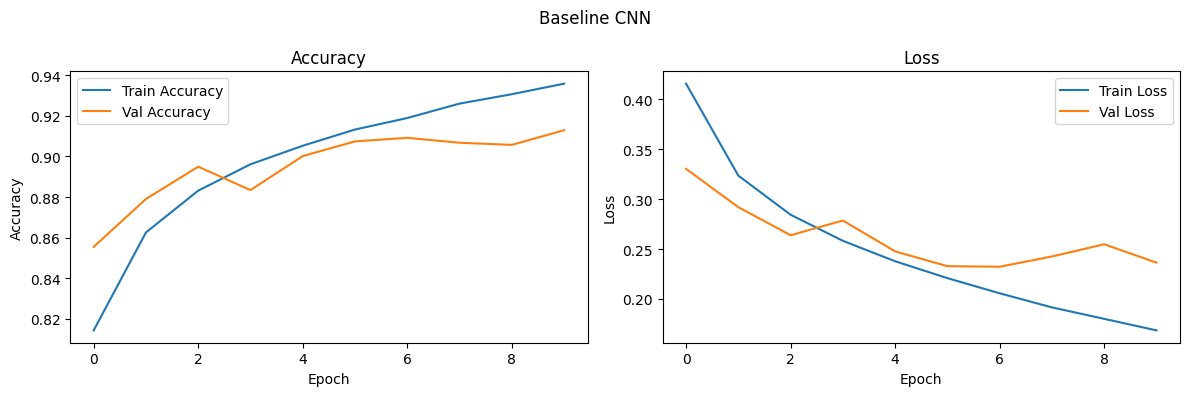

In [130]:
plot_history(history_cnn, "Baseline CNN")

The initial attempt at Transfer Learning using EfficientNetB0 showed no training progression. Both accuracy and loss curves are nearly flat, this suggests failure in learning from the data. This failure shows the importance of correct preprocessing.

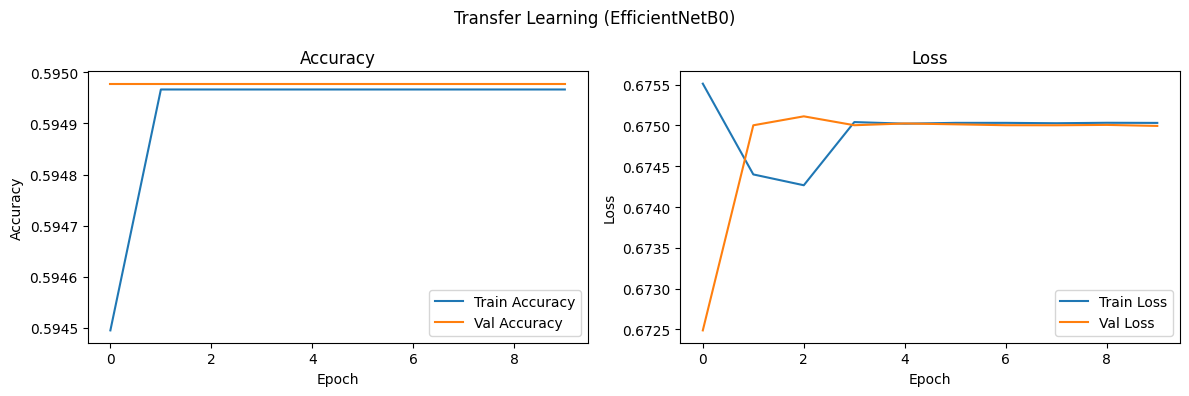

In [132]:
plot_history(history_transfer, "Transfer Learning (EfficientNetB0)")

The plot below shows improved performance of the transfer learning model. Both the training and validation accuracy increased consistently across epochs. The validation accuracy is slightly higher than training. Both the training and validation loss decrease steadily, this indicates the model is learning. The final loss dropping to about 0.26, compared to the .67 in the earlier model.

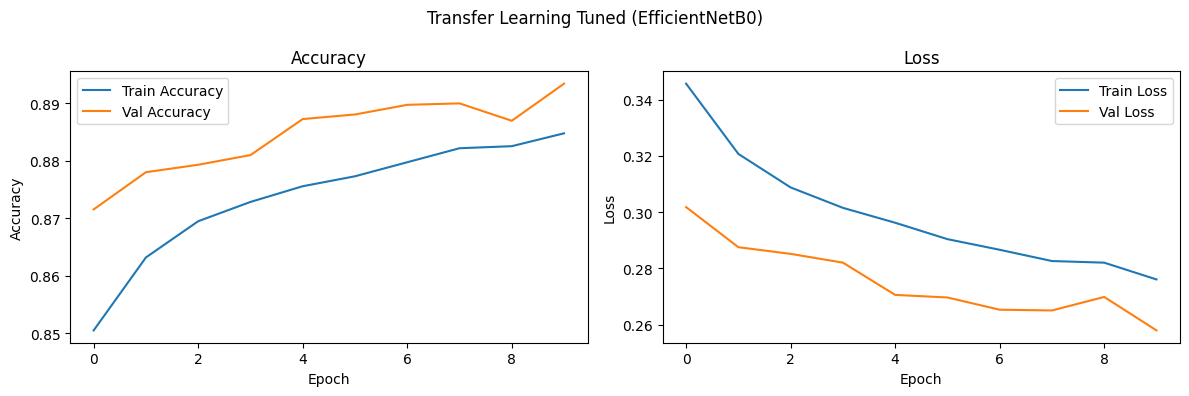

In [133]:
plot_history(history_transfer_02, "Transfer Learning Tuned (EfficientNetB0)")

Tune the Baseline CNN slightly. Adding more convolutional layers, a specified learning rate, batch normalization, and increased the dense layer size.

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [33]:
def build_deeper_cnn(input_shape=(96, 96, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model

Also adding EarlyStopping to prevent overfitting.

In [34]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [35]:
deeper_model = build_deeper_cnn()

history_deeper = deeper_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)

c:\College\CU_Boulder\Machine Learning\CSCA_5642\Week 3\project\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\College\CU_Boulder\Machine Learning\CSCA_5642\Week 3\project\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1050s 191ms/step - accuracy: 0.8134 - auc_3: 0.8761 - loss: 0.4697 - val_accuracy: 0.8310 - val_auc_3: 0.9510 - val_loss: 0.4216
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 467s 85ms/step - accuracy: 0.8909 - auc_3: 0.9487 - loss: 0.2824 - val_accuracy: 0.8942 - val_auc_3: 0.9580 - val_loss: 0.2657
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 470s 85ms/step - accuracy: 0.9117 - auc_3: 0.9647 - loss: 0.2325 - val_accuracy: 0.7279 - val_auc_3: 0.6620 - val_loss: 5.3208
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 465s 84ms/step - accuracy: 0.9209 - auc_3: 0.9718 - loss: 0.2074 - val_accuracy: 0.9043 - val_auc_3: 0.9542 - val_loss: 0.2742
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 465s 85ms/step - accuracy: 0.9299 - auc_3: 0.9767 - loss: 0.1873 - val_accuracy: 0.8863 - val_auc_3: 0.9494 - val_loss: 0.3401


Deeper CNN Model: Compared to the baseline CNN, the depth was increased, added batch normalization, increased the dense layer size from 128 to 256, lower learning rate, and added a stop training if validation loss doesn't improve over 3 epochs. The training accuracy increased to about 93%, indicating the model fits the training data well. The validation accuracy was strong, at about 90%, but drops sharply in epoch 3, this suggests instability or overfitting, it then recovers. The training loss decreased smoothly, the validation has a spike at epoch 3 again. This could possibly be from overfitting, the BatchNorm or Dropout.
The Deeper CNN had a similar performance to the baseline, but with more volatility. Further tuning may include data augmentation, learning rate schedulers, or try reducing the filters.

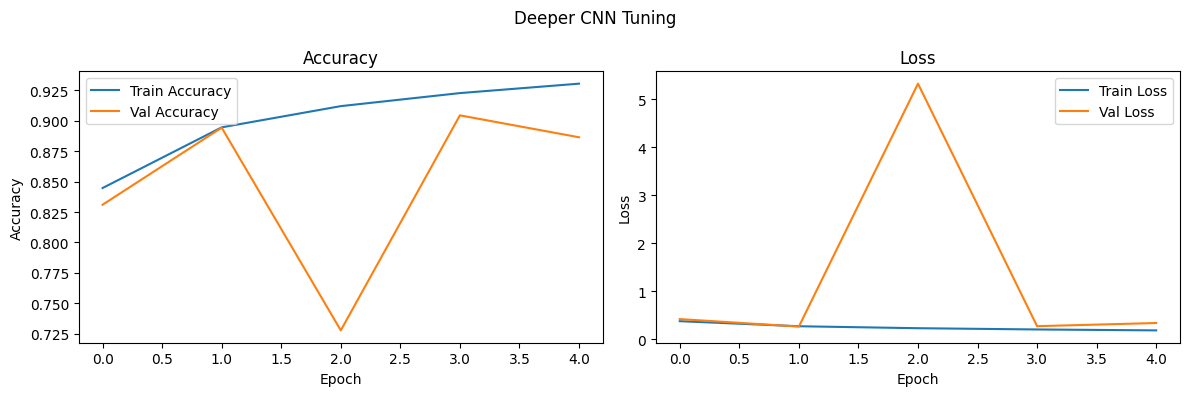

In [38]:
plot_history(history_deeper, "Deeper CNN Tuning")

Throughout the project, various convolution neural network (CNN) architectures were explored for histopathologic cancer detection, comparing a custom-built baseline CNN, a transfer learning approach using EfficientNetB0, and a deeper tuned CNN.

The baseline CNN performed well, reaching a validation accuracy ~91.3% and AUC or ~0.9678. Its simple structure proved effective and stable, showing a consistent learning trend across the epochs. Indicating that for this image classification problem, even a relatively shallow CNN can extract meaningful features when trained on a large and clean dataset.

The initial transfer learning results with EfficientNetB0 were underwhelming. When images were not properly preprocessed using EfficientNet's preprocess_input, performance stagnated around ~59% accuracy, indicating a mismatch between the expected input distribution and data. However, once the correct preprocessing was applied, the transfer model significantly improved, reaching a validation accuracy of ~89% and AUC of ~.95.

A deeper custom CNN with more laters and batch normalization was implemented as well. This model performed comparably to the baseline but suffered from training instability, as evidenced by sudden spikes in validation loss mid-training. Although its peak performance approached the baseline, it did not outperform it consistently. This suggests the model may have been too complex for the data without more regularization or tuning.